In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import os
import json
from collections import defaultdict
import glob
import matplotlib.pyplot as plt

# ResourceGroups

In [2]:
data = []
json_files = glob.glob('fctryengine_outputs/data/*.json')

for file in json_files:
    with open(file, 'r') as f:
        data.append(json.load(f))


In [3]:
ResourceGroups = data[0]
Resources = data[1]
Tasks = data[2]

In [4]:
RG2ResourceCount = {RG['resource_group_id']:len(RG['resource_id']) for RG in  ResourceGroups}

In [6]:
df_dict = defaultdict(list)
for t in Tasks:
    for RG in t['resource_group_id']:
        df_dict['taskno'].append(t['taskno'])
        df_dict['duration'].append(t['duration'])
        df_dict['ResourceGroup'].append(RG)
        df_dict['NumResources'].append(RG2ResourceCount[RG])

ResourceDf = pd.DataFrame(df_dict)
ResourceDf.head()

,taskno,duration,ResourceGroup,NumResources
0,WO20946-10,30,38,2
1,WO29559-10,30,67,7
2,WO30798-20,120,3,1
3,WO30819-20,30,3,1
4,WO30820-20,30,3,1


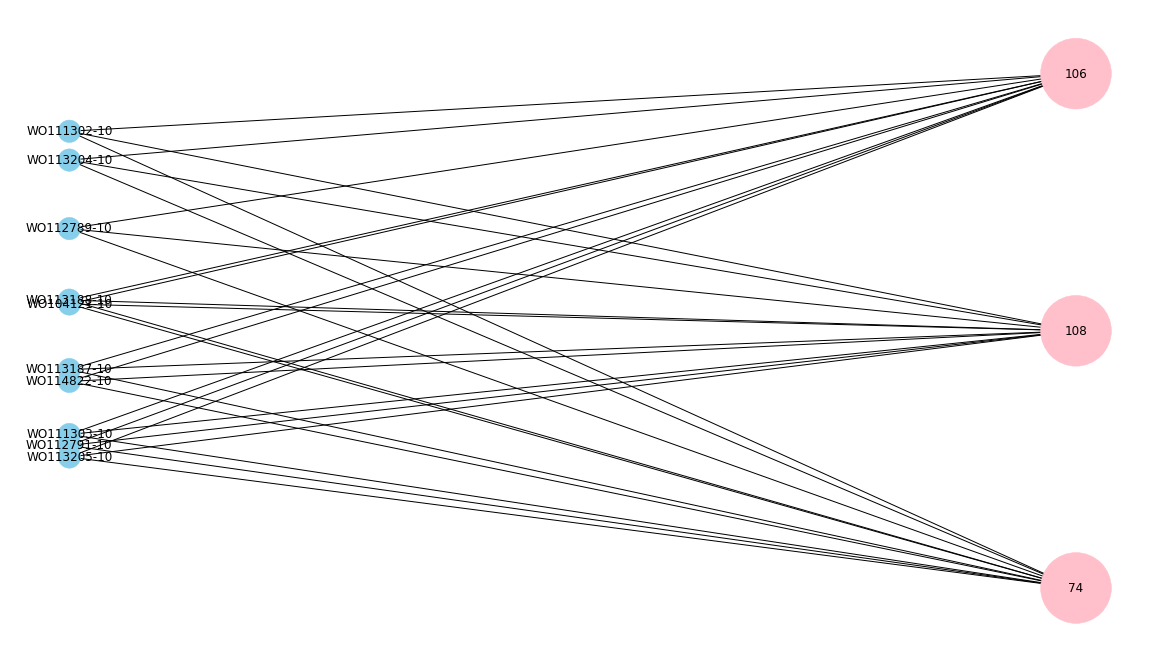

In [18]:
import networkx as nx
from networkx.algorithms import bipartite

B = nx.Graph()
B.add_nodes_from(ResourceDf['taskno'].unique(), bipartite=0)
B.add_nodes_from(ResourceDf['ResourceGroup'].unique(), bipartite=1)
B.add_edges_from(list(zip(ResourceDf['taskno'], ResourceDf['ResourceGroup'])))


top_nodes = sorted(B.degree(), key=lambda x: x[1], reverse=True)
top_nodes_bipartite_0 = [node for node in top_nodes if B.nodes[node[0]]['bipartite'] == 0][:10]

ego_graphs = []
for node in top_nodes_bipartite_0:
    ego_graph = nx.ego_graph(B, node[0])
    ego_graphs.append(ego_graph)

combined_graph = nx.compose_all(ego_graphs)





#pos = nx.bipartite_layout(combined_graph, nodes=ResourceDf['taskno'].unique())
#nx.draw(combined_graph, pos, node_color=['skyblue' if combined_graph.nodes[n]['bipartite'] == 0 else 'pink' for n in combined_graph.nodes], with_labels=True)




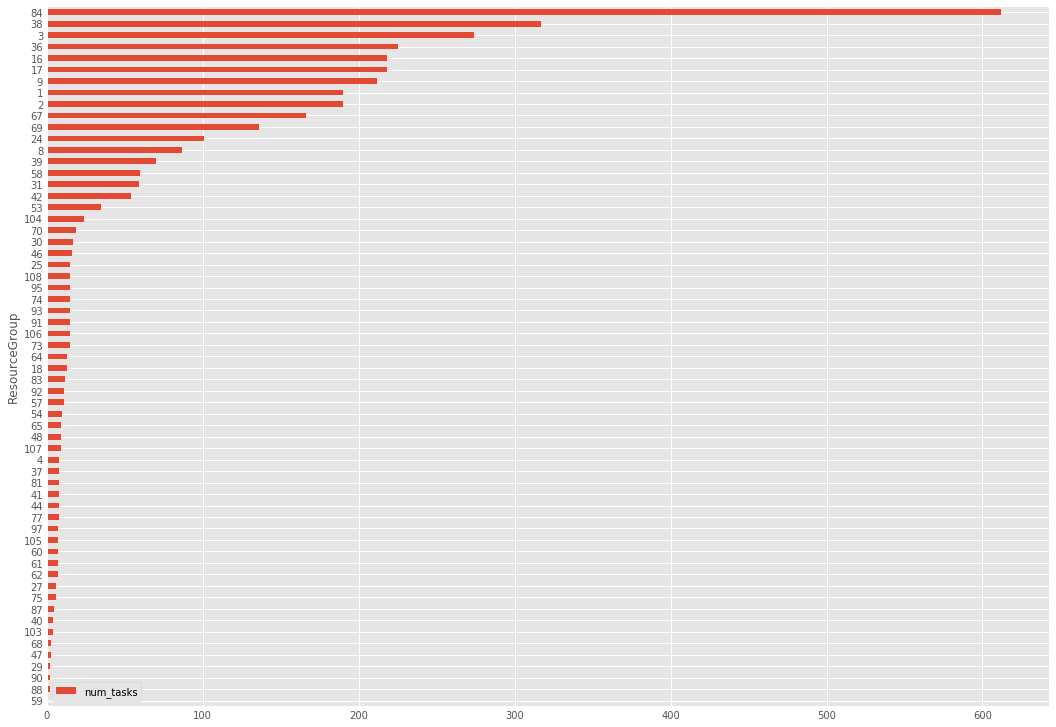

In [19]:
plt.style.use('ggplot')
TasksPrRG = ResourceDf.groupby('ResourceGroup').count().sort_values('taskno',ascending = True).reset_index()
TasksPrRG = TasksPrRG[['ResourceGroup','taskno']]
TasksPrRG['num_tasks'] = TasksPrRG['taskno']
TasksPrRG.drop('taskno',axis=1,inplace=True)

TasksPrRG.plot(kind='barh',x='ResourceGroup',y='num_tasks',figsize = [16,12])

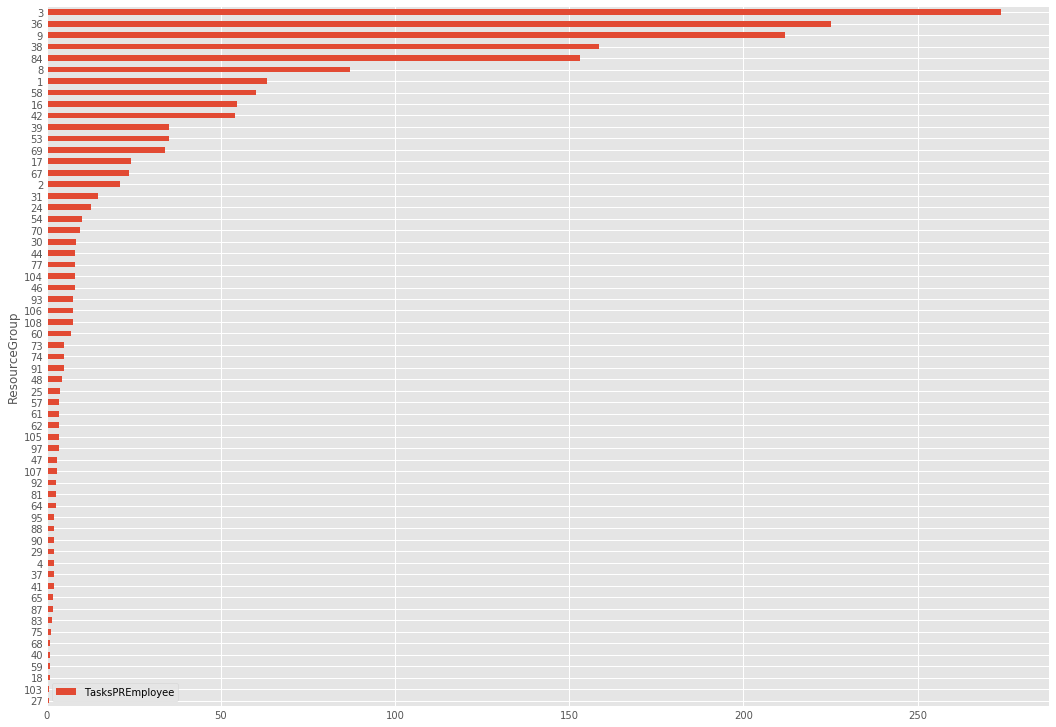

In [20]:

TasksPrEmployee = TasksPrRG.merge(ResourceDf[['ResourceGroup','NumResources']])
TasksPrEmployee['TasksPREmployee'] = TasksPrEmployee['num_tasks']/TasksPrEmployee['NumResources']
TasksPrEmployee = TasksPrEmployee.sort_values('TasksPREmployee',ascending = True)
TasksPrEmployee.drop_duplicates(inplace=True)
TasksPrEmployee.plot(kind='barh',x='ResourceGroup',y='TasksPREmployee',figsize = [16,12])


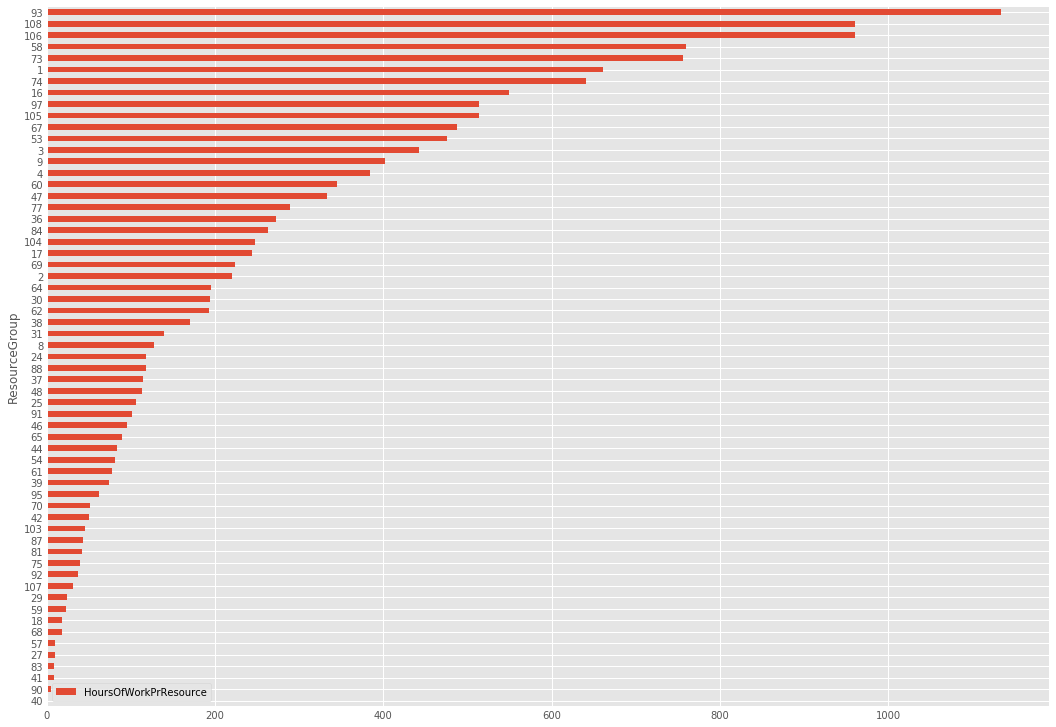

In [21]:

Durations = ResourceDf[['ResourceGroup','duration']].groupby('ResourceGroup').sum().reset_index()
Durations = Durations.merge(ResourceDf[['ResourceGroup','NumResources']])
Durations['HoursOfWorkPrResource'] = Durations['duration']/Durations['NumResources']/60

Durations = Durations.sort_values('HoursOfWorkPrResource',ascending = True)
Durations.drop_duplicates(inplace=True)
Durations.plot(kind='barh',x='ResourceGroup',y='HoursOfWorkPrResource',figsize = [16,12])

In [79]:
RGNameLookup = {RG['resource_group_id']:RG['resource_group_name'] for RG in ResourceGroups}
for rg in [93,108,106,58,73,1,74,16,97,105]:
    pass#print(f"{rg} : ",RGNameLookup[rg])


for rg in [84,3,36,9,58]:
    print(f"{rg} : ",RGNameLookup[rg])

84 :  Laser
3 :  Bending
36 :  Saw
9 :  Afsyring - overfladebehandling
58 :  Lathing - Puma 600


# Scheduler

In [69]:
WorkOrders = pd.read_csv('WorkOrders.csv')
WorkOrders['ETA'] = pd.to_datetime(WorkOrders['ETA'])
WorkOrders['DueDate'] = pd.to_datetime(WorkOrders['DueDate'])
WorkOrders['Delay'] = pd.to_timedelta(WorkOrders['Delay'])
WorkOrders['DelayWithoutIdleTime'] = pd.to_timedelta(WorkOrders['DelayWithoutIdleTime'])
WorkOrders['TimeDifference'] = pd.to_timedelta(WorkOrders['TimeDifference'])


# Orders being done to late
WorkOrders.loc[(~WorkOrders['DueDate'].isna())&(WorkOrders['DelayWithoutIdleTime']>pd.Timedelta(0))].sort_values('TimeDifference',ascending=False).head(5)

,Priority,WorkOrder,capable_resource_groups,idle_minutes,ETA,DueDate,Delay,DelayWithoutIdleTime,TimeDifference
689,281,WO114449-10,58,34406,2024-03-07 14:11:00,2024-01-31,36 days 14:11:00,12 days 16:45:00,23 days 21:26:00
690,281,WO114455-10,58,33038,2024-03-04 12:28:00,2024-01-31,33 days 12:28:00,10 days 13:50:00,22 days 22:38:00
3098,339,WO30819-20,3,32161,2024-02-27 09:55:00,2023-01-03,420 days 09:55:00,398 days 01:54:00,22 days 08:01:00
3101,327,WO49921-20,3,32121,2024-02-27 09:25:00,2020-10-06,1239 days 09:25:00,1217 days 02:04:00,22 days 07:21:00
3100,326,WO33143-20,3,31920,2024-02-27 08:45:00,2020-03-02,1457 days 08:45:00,1435 days 04:45:00,22 days 04:00:00


In [70]:
# Orders being done before time
WorkOrders.loc[(~WorkOrders['DueDate'].isna())&(WorkOrders['DelayWithoutIdleTime']<pd.Timedelta(0))].sort_values('TimeDifference',ascending=True).head(5)

,Priority,WorkOrder,capable_resource_groups,idle_minutes,ETA,DueDate,Delay,DelayWithoutIdleTime,TimeDifference
1611,285,WO116778-10,16|17,0,2024-01-08 11:37:00,2024-01-31,-23 days +11:37:00,-23 days +11:37:00,0 days
624,30,WO114308-20,39,0,2023-11-27 07:50:00,2023-12-20,-23 days +07:50:00,-23 days +07:50:00,0 days
621,30,WO114307-20,39,0,2023-11-27 11:50:00,2023-12-20,-23 days +11:50:00,-23 days +11:50:00,0 days
619,30,WO114306-30,31,0,2023-11-28 08:05:00,2023-12-20,-22 days +08:05:00,-22 days +08:05:00,0 days
618,30,WO114306-20,39,0,2023-11-27 10:30:00,2023-12-20,-23 days +10:30:00,-23 days +10:30:00,0 days


In [42]:
# Group by Priority to get max delay
max_due_date_per_priority = WorkOrders.groupby('Priority')['DueDate'].idxmax().dropna()
max_due_date_df = WorkOrders.loc[max_due_date_per_priority]

max_due_date_df['DelayDays'] = max_due_date_df['Delay'].dt.total_seconds() / 86400

max_due_date_df = max_due_date_df.loc[max_due_date_df.groupby('Priority')['DelayDays'].idxmax()]
max_due_date_df.sort_values('Priority')

,Priority,WorkOrder,capable_resource_groups,idle_minutes,ETA,DueDate,Delay,DelayWithoutIdleTime,TimeDifference,DelayDays
305.0,1,WO111980-10,38,0,2023-11-27 07:30:00,2023-11-27,0 days 07:30:00,0 days 07:30:00,0 days 00:00:00,0.312500
511.0,2,WO113974-10,38,0,2023-11-27 07:30:00,2023-11-27,0 days 07:30:00,0 days 07:30:00,0 days 00:00:00,0.312500
448.0,3,WO112849-10,67,0,2023-12-07 07:43:00,2023-11-27,10 days 07:43:00,10 days 07:43:00,0 days 00:00:00,10.321528
942.0,5,WO115336-10,38,0,2023-11-27 11:51:00,2023-11-27,0 days 11:51:00,0 days 11:51:00,0 days 00:00:00,0.493750
993.0,6,WO115651-10,38,0,2023-11-28 10:25:00,2023-11-27,1 days 10:25:00,1 days 10:25:00,0 days 00:00:00,1.434028
...,...,...,...,...,...,...,...,...,...,...
3111.0,335,WO84929-10,77,20262,2024-02-01 07:16:00,2022-06-30,581 days 07:16:00,567 days 05:34:00,14 days 01:42:00,581.302778
3113.0,336,WO84985-10,2|1,1097,2023-11-28 14:31:00,2022-07-25,491 days 14:31:00,490 days 20:14:00,0 days 18:17:00,491.604861
3112.0,337,WO84984-10,2|1,1123,2023-11-28 14:57:00,2022-08-03,482 days 14:57:00,481 days 20:14:00,0 days 18:43:00,482.622917
3098.0,339,WO30819-20,3,32161,2024-02-27 09:55:00,2023-01-03,420 days 09:55:00,398 days 01:54:00,22 days 08:01:00,420.413194


-39.295 179.1916666666667 218.48666666666668


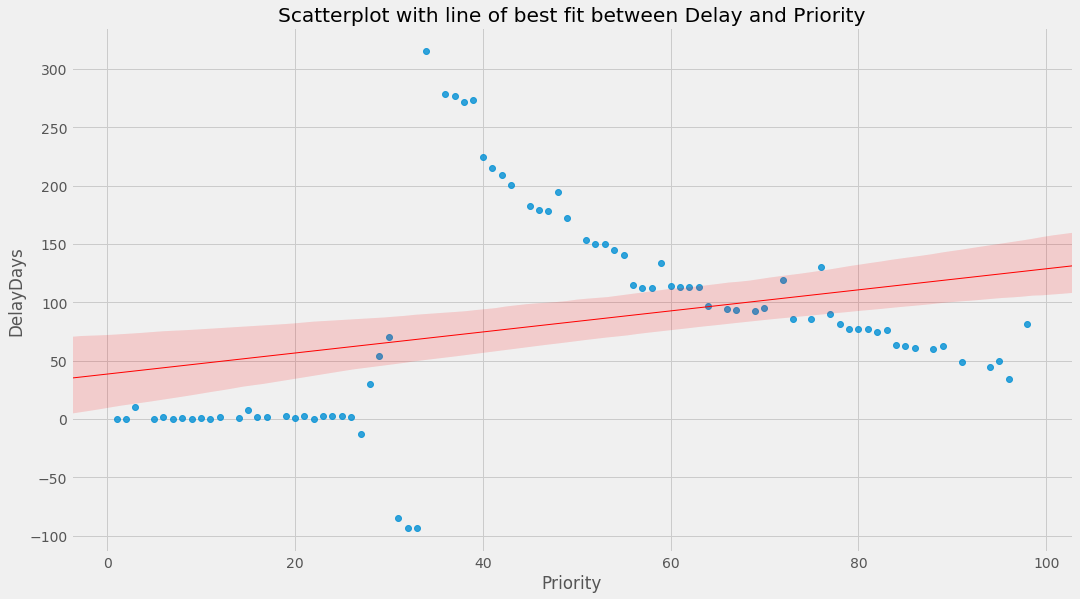

In [86]:
Q1 = max_due_date_df['DelayDays'].quantile(0.1)
Q3 = max_due_date_df['DelayDays'].quantile(0.9)

IQR = Q3 - Q1

print(Q1,Q3,IQR)

max_due_date_df_ = max_due_date_df[~((max_due_date_df['DelayDays'] < (Q1 - 1.5 * IQR)) | (max_due_date_df['DelayDays'] > (Q3 + 1.5 * IQR)))]


max_due_date_df_top_100 = max_due_date_df_.loc[max_due_date_df_['Priority']<=100]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,9))
sns.regplot(x='Priority', y='DelayDays', data=max_due_date_df_top_100, line_kws={"color": "red",'linewidth':1})
plt.title('Scatterplot with line of best fit between Delay and Priority')
plt.show()


In [49]:
max_due_date_df['Density'] = max_due_date_df.groupby('DueDate')['DueDate'].transform('count')
#max_due_date_df['Density'] = max_due_date_df['Density'].apply(lambda x: 'High' if x > max_due_date_df['Density'].mean() else 'Low')
max_due_date_df


,Priority,WorkOrder,capable_resource_groups,idle_minutes,ETA,DueDate,Delay,DelayWithoutIdleTime,TimeDifference,DelayDays,Density
305.0,1,WO111980-10,38,0,2023-11-27 07:30:00,2023-11-27,0 days 07:30:00,0 days 07:30:00,0 days 00:00:00,0.312500,23
511.0,2,WO113974-10,38,0,2023-11-27 07:30:00,2023-11-27,0 days 07:30:00,0 days 07:30:00,0 days 00:00:00,0.312500,23
448.0,3,WO112849-10,67,0,2023-12-07 07:43:00,2023-11-27,10 days 07:43:00,10 days 07:43:00,0 days 00:00:00,10.321528,23
942.0,5,WO115336-10,38,0,2023-11-27 11:51:00,2023-11-27,0 days 11:51:00,0 days 11:51:00,0 days 00:00:00,0.493750,23
993.0,6,WO115651-10,38,0,2023-11-28 10:25:00,2023-11-27,1 days 10:25:00,1 days 10:25:00,0 days 00:00:00,1.434028,23
...,...,...,...,...,...,...,...,...,...,...,...
3111.0,335,WO84929-10,77,20262,2024-02-01 07:16:00,2022-06-30,581 days 07:16:00,567 days 05:34:00,14 days 01:42:00,581.302778,1
3113.0,336,WO84985-10,2|1,1097,2023-11-28 14:31:00,2022-07-25,491 days 14:31:00,490 days 20:14:00,0 days 18:17:00,491.604861,1
3112.0,337,WO84984-10,2|1,1123,2023-11-28 14:57:00,2022-08-03,482 days 14:57:00,481 days 20:14:00,0 days 18:43:00,482.622917,1
3098.0,339,WO30819-20,3,32161,2024-02-27 09:55:00,2023-01-03,420 days 09:55:00,398 days 01:54:00,22 days 08:01:00,420.413194,1


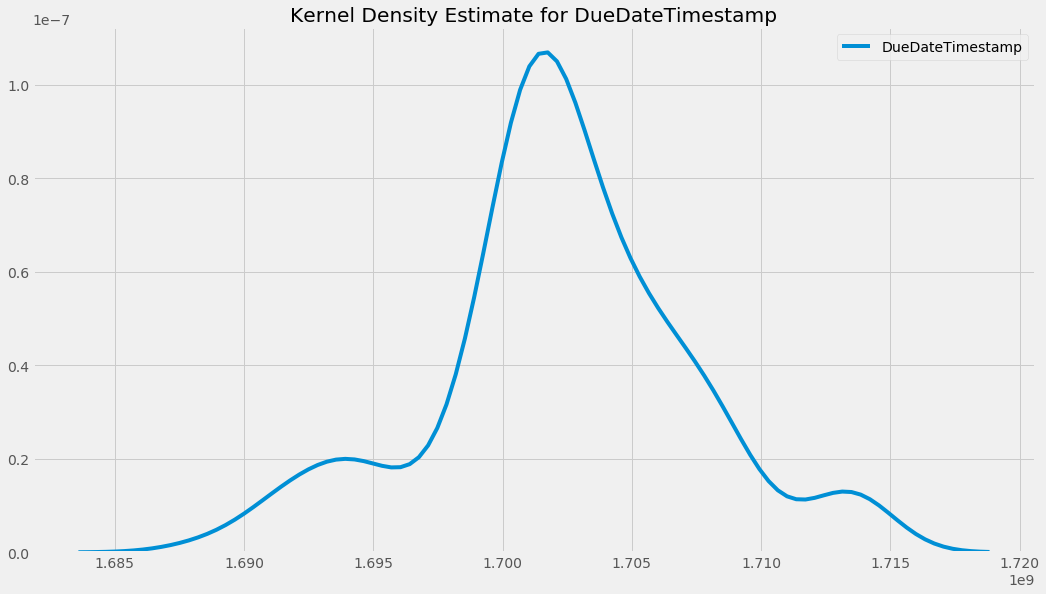

/home/askm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/askm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82d8445d68>]],
      dtype=object)

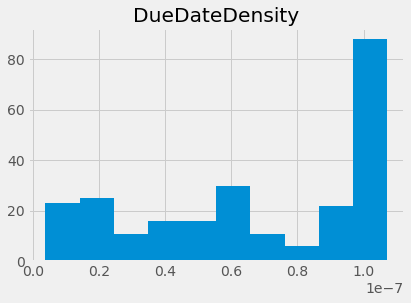

In [67]:
from scipy.stats import gaussian_kde

max_due_date_df['DueDateTimestamp'] = max_due_date_df['DueDate'].apply(lambda x: x.timestamp())
Q1 = max_due_date_df['DueDateTimestamp'].quantile(0.25)
Q3 = max_due_date_df['DueDateTimestamp'].quantile(0.75)
IQR = Q3 - Q1
max_due_date_df_excluded = max_due_date_df[~((max_due_date_df['DueDateTimestamp'] < (Q1 - 1.5 * IQR)) | (max_due_date_df['DueDateTimestamp'] > (Q3 + 1.5 * IQR)))]

#max_due_date_df['DueDateTimestamp'] = max_due_date_df['DueDate'].apply(lambda x: x.timestamp())
kde = gaussian_kde(max_due_date_df_excluded['DueDateTimestamp'].dropna().values)
plt.figure(figsize=(16, 9))
sns.kdeplot(max_due_date_df_excluded['DueDateTimestamp'])
plt.title('Kernel Density Estimate for DueDateTimestamp')
plt.show()

max_due_date_df_excluded['DueDateDensity'] = max_due_date_df_excluded['DueDateTimestamp'].apply(kde.evaluate)


max_due_date_df_excluded['DueDateDensity'] = [val[0] for val in max_due_date_df_excluded['DueDateDensity'].values]
max_due_date_df_excluded.hist("DueDateDensity")


/home/askm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/askm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


-1204714586.6369622 3923605723.2050805 5128320309.842043


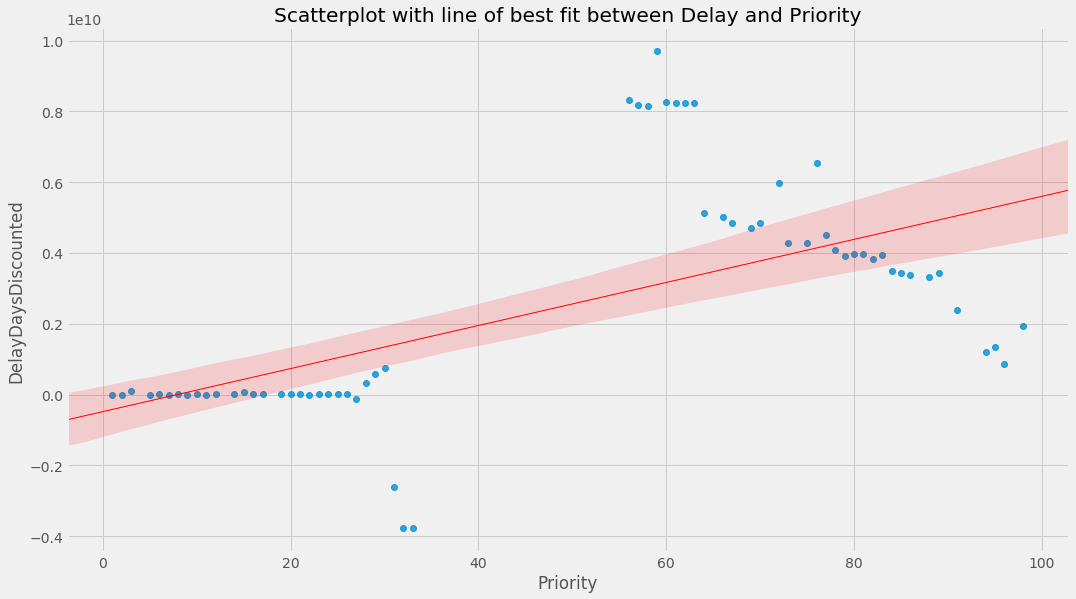

In [83]:
# Discount it with the current pressure on the system? 


#max_due_date_df['Density'] = max_due_date_df.groupby('DueDate')['DueDate'].transform('count')
#max_due_date_df['Density'] = max_due_date_df['Density'].apply(lambda x: 'High' if x > max_due_date_df['Density'].mean() else 'Low')



max_due_date_df_excluded['DelayDaysDiscounted'] = max_due_date_df_excluded['DelayDays']/max_due_date_df_excluded['DueDateDensity']

Q1 = max_due_date_df_excluded['DelayDaysDiscounted'].quantile(0.1)
Q3 = max_due_date_df_excluded['DelayDaysDiscounted'].quantile(0.9)

IQR = Q3 - Q1

print(Q1,Q3,IQR)

max_due_date_df_discounted = max_due_date_df_excluded[~((max_due_date_df['DelayDaysDiscounted'] < (Q1 - 1.5 * IQR)) | (max_due_date_df_excluded['DelayDaysDiscounted'] > (Q3 + 1.5 * IQR)))]



max_due_date_df_discounted_top_100 = max_due_date_df_discounted.loc[max_due_date_df_discounted['Priority']<=100]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,9))
sns.regplot(x='Priority', y='DelayDaysDiscounted', data=max_due_date_df_discounted_top_100, line_kws={"color": "red",'linewidth':1})
plt.title('Scatterplot with line of best fit between Delay and Priority')
plt.show()


In [54]:
max_due_date_df.loc[max_due_date_df['Priority'].isin([i for i in range(45,70)])]

,Priority,WorkOrder,capable_resource_groups,idle_minutes,ETA,DueDate,Delay,DelayWithoutIdleTime,TimeDifference,DelayDays,Density,DelayDaysDiscounted
8.0,45,WO100946-20,104,0,2023-11-27 07:00:00.000,2023-05-29,182 days 07:00:00,182 days 07:00:00,0 days 00:00:00,182.291667,1,182.291667
84.0,46,WO107121-20,69,0,2023-11-27 07:00:00.000,2023-06-01,179 days 07:00:00,179 days 07:00:00,0 days 00:00:00,179.291667,1,179.291667
22.0,47,WO102847-20,104,0,2023-11-27 07:00:00.000,2023-06-02,178 days 07:00:00,178 days 07:00:00,0 days 00:00:00,178.291667,2,89.145833
101.0,48,WO108551-10,9,5666,2023-12-13 06:45:00.000,2023-06-02,194 days 06:45:00,190 days 08:19:00,3 days 22:26:00,194.281250,2,97.140625
107.0,49,WO108857-10,8,30,2023-11-27 10:05:00.000,2023-06-08,172 days 10:05:00,172 days 09:35:00,0 days 00:30:00,172.420139,1,172.420139
9.0,51,WO101246-10,2|1,30,2023-11-27 07:29:57.000,2023-06-27,153 days 07:29:57,153 days 06:59:57,0 days 00:30:00,153.312465,1,153.312465
31.0,52,WO103940-10,58,131,2023-11-27 09:11:00.000,2023-06-30,150 days 09:11:00,150 days 07:00:00,0 days 02:11:00,150.382639,2,75.191319
29.0,53,WO103935-10,58,161,2023-11-27 10:05:00.000,2023-06-30,150 days 10:05:00,150 days 07:24:00,0 days 02:41:00,150.420139,2,75.210069
164.0,54,WO110244-10,69,30,2023-11-27 08:42:00.000,2023-07-05,145 days 08:42:00,145 days 08:12:00,0 days 00:30:00,145.362500,1,145.362500
114.0,55,WO109612-20,70,30,2023-11-27 11:26:00.000,2023-07-10,140 days 11:26:00,140 days 10:56:00,0 days 00:30:00,140.476389,1,140.476389


/home/askm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


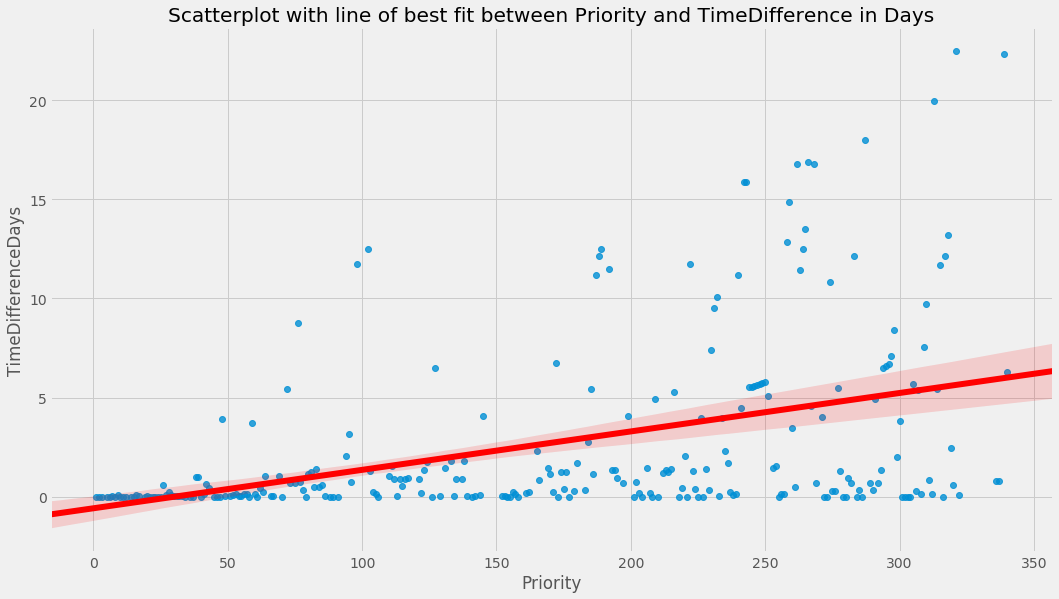

In [37]:
max_due_date_df_['TimeDifferenceDays'] = max_due_date_df_['TimeDifference'].dt.total_seconds() / 86400
plt.figure(figsize=(16,9))
sns.regplot(x='Priority', y='TimeDifferenceDays', data=max_due_date_df_, line_kws={"color": "red"})
plt.title('Scatterplot with line of best fit between Priority and TimeDifference in Days')
plt.show()


## Idle Time

In [81]:
idle_groups = defaultdict(int)
for k,row in WorkOrders.iterrows():
    for RG in row['capable_resource_groups'].split('|'):
        idle_groups[RG]+=row['idle_minutes']/100


idleframe = pd.DataFrame({'ResourceGroups':idle_groups.keys(),
              'IdleMinutes':idle_groups.values()})

idleframe.sort_values('IdleMinutes',ascending=False)

,ResourceGroups,IdleMinutes
32,84,138107.82
33,3,29419.76
11,36,20217.30
19,9,12463.88
15,58,10409.24
10,69,10034.97
22,31,6339.14
7,38,4685.92
12,67,4167.20
4,2,3059.43
